# Import Libs

In [1]:
import tensorflow as tf ### models
import matplotlib.pylab as plt ### ploting
import seaborn as sns
import numpy as np ### math computations
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, BatchNormalization, Input, Layer,Dropout,
                                     RandomFlip, RandomRotation, Resizing, Rescaling #for augmentation
                                     )
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, TruePositives, FalsePositives, FalseNegatives, TrueNegatives,Precision,Recall, AUC
from sklearn.metrics import confusion_matrix, roc_curve,f1_score

from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

import cv2


In [2]:
tf.__version__

'2.10.0'

# Load Malaria Dataset

In [3]:
dataset, dataset_info = tfds.load('malaria',with_info=True, as_supervised=True, shuffle_files = True, split = 'train')

In [4]:
tfds.__version__

'4.9.2'

# Data Split

In [5]:
TRANI_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [6]:
def splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_dataset = dataset.take(int(TRANI_RATIO*DATASET_SIZE))
    val_test__dataset = dataset.skip(int(TRANI_RATIO*DATASET_SIZE))
    val_dataset = val_test__dataset.take(int(VAL_RATIO*DATASET_SIZE))
    test_dataset = val_test__dataset.skip(int(VAL_RATIO*DATASET_SIZE))
    return train_dataset, val_dataset, test_dataset


In [7]:
#dataset = tf.data.Dataset.range(20)
train_dataset, val_dataset, test_dataset = splits(dataset, TRANI_RATIO, VAL_RATIO, TEST_RATIO)

# Data Visualizing

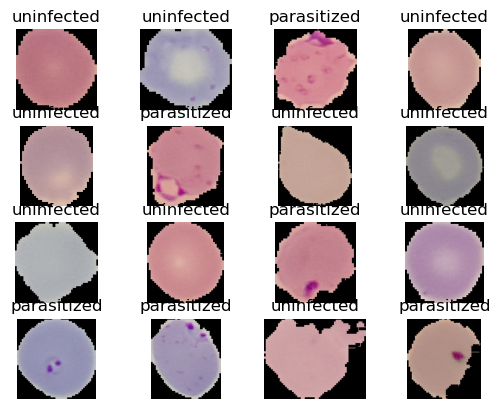

In [8]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [9]:
 dataset_info.features['label'].int2str(0)

'parasitized'

# Augmentation

## tf.image augment

In [10]:
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0,label

In [11]:
IM_SIZE = 224

In [12]:
## tf.image augment
def augment(image, label):
    image, label = resize_rescale(image, label)
    image = tf.image.rot90(image)
    image = tf.image.flip_left_right(image)
    return image, label

In [13]:
class RotNinty(Layer):
  def __init__(self):
    super().__init__()
  def call(self, image):
    return tf.image.rot90(image)

# tf.keras.layers

In [14]:
resizing_rescaling_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1.0/255)
])

In [15]:
## tf.keras.layers augment
augment_layers = tf.keras.Sequential([
    RotNinty(),
    RandomFlip(mode='horizontal', )
])

def augment_layer(image, label):
  return augment_layers(resizing_rescaling_layers(image), training = True), label

# Mixup Augmentation

In [16]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration= True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [17]:
def mixup(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]

    image = lamda*image_1 + (1- lamda *image_2)
    label = lamda*tf.cast(label_1, dtype = tf.float32) + (1 - lamda * tf.cast(label_2, dtype = tf.float32))

    return image, label

## CutMixup Augmentation

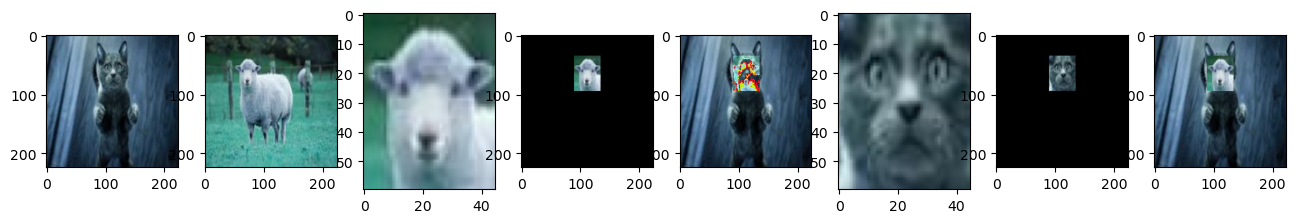

In [18]:
IM_SIZE = 224
plt.figure(figsize= (16, 8))
plt.subplot(1, 8, 1)
image_1 = cv2.resize(cv2.imread("cat.jpg"), (IM_SIZE, IM_SIZE))
tensor_image_1 = tf.convert_to_tensor(image_1, dtype=tf.int32)
plt.imshow(image_1)

plt.subplot(1, 8, 2)
image_2 = cv2.resize(cv2.imread("sheep.jpg"), (IM_SIZE, IM_SIZE))
tensor_image_2 = tf.convert_to_tensor(image_2, dtype=tf.int32)
plt.imshow(image_2)

plt.subplot(1, 8, 3)
crop_image_2 = tf.image.crop_to_bounding_box(image_2, 35,50, 60,45)
plt.imshow(crop_image_2)

plt.subplot(1, 8, 4)
pad_crop_image_2 = tf.image.pad_to_bounding_box(crop_image_2, 35,90, IM_SIZE,IM_SIZE)
plt.imshow(pad_crop_image_2)

plt.subplot(1, 8, 5)
plt.imshow(image_1 + pad_crop_image_2)

plt.subplot(1, 8, 6)
crop_image_1 = tf.image.crop_to_bounding_box(image_1, 35,90, 60,45)
plt.imshow(crop_image_1)

plt.subplot(1, 8, 7)
pad_crop_image_1 = tf.image.pad_to_bounding_box(crop_image_1, 35,90, IM_SIZE,IM_SIZE)
plt.imshow(pad_crop_image_1)

plt.subplot(1, 8, 8)
plt.imshow(tf.cast(tensor_image_1, dtype=tf.int32) - tf.cast(pad_crop_image_1, dtype=tf.int32) + tf.cast(pad_crop_image_2, dtype=tf.int32) )

In [19]:
def box(lamda):
  r_x_center = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y_center = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.square(1 - lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.square(1 - lamda), dtype = tf.int32)

  x_t_l = tf.clip_by_value(r_x_center - r_w//2, 0, IM_SIZE)
  y_t_l = tf.clip_by_value(r_y_center - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x_center + r_w//2 , 0 , IM_SIZE)
  y_b_r = tf.clip_by_value(r_y_center + r_h//2 , 0 , IM_SIZE)

  r_w = x_b_r - x_t_l
  if(r_w==0):
    r_w = 1

  r_h = y_b_r - y_t_l
  if(r_h==0):
    r_h = 1

  return y_t_l, x_t_l, r_h, r_w


In [20]:
def cutmix(train_dataset_1, train_dataset_2):
    (image_1, label_1), (image_2, label_2) = train_dataset_1, train_dataset_2
    lamda = tfp.distributions.Beta(0.2, 0.2)
    lamda = lamda.sample(1)[0]

    r_y, r_x, r_h, r_w = box(lamda)
    crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
    pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y,r_x, IM_SIZE,IM_SIZE)

    crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
    pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y,r_x, IM_SIZE,IM_SIZE)

    image = image_1 -pad_1 + pad_2

    labda = tf.cast(1 - (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
    label = lamda*tf.cast(label_1, dtype = tf.float32) + (1 - lamda * tf.cast(label_2, dtype = tf.float32))

    return image, label

# Data Preprocessing

In [21]:
BATCH_SIZE = 32
train_dataset = (mixed_dataset
                 .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                 .map(cutmix) # augmentation with cutmix
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size= 8 , reshuffle_each_iteration= True)
                .map(resize_rescale) # Just resizing and rescaling
               .batch(BATCH_SIZE)
               .prefetch(tf.data.AUTOTUNE))

#test_dataset = test_dataset.map(resizing_rescaling_layers)

# Model Subclassing

In [22]:
class FeatureExtractor(Layer):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, droupout_rate, regularizer_rate):
        super(FeatureExtractor, self).__init__()
        self.conv_1 = Conv2D(filters= num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.pool_1 = MaxPooling2D(pool_size=pool_size, strides=num_strides)

        self.conv_2 = Conv2D(filters= 2*num_filters,kernel_size=kernel_size, strides=num_strides, padding= padding, activation = activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=pool_size, strides=2*num_strides)

    def call(self, x, training):
        x = self.conv_1(x)
        x = self.batch_1(x)
        x = self.droupout1(x)
        x = self.pool_1(x)


        x = self.conv_2(x)
        x = self.batch_2(x)
        x = self.pool_2(x)

        return x

In [23]:
feature_sub_classed = FeatureExtractor(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2), droupout_rate = 0.3, regularizer_rate = 0.01)

In [24]:
class LenetModel(Model):
    def __init__(self, num_filters, kernel_size,num_strides, padding, activation_function, pool_size, output_activation,droupout_rate, regularizer_rate):
        super(LenetModel, self).__init__()

        self.featureExtractor = FeatureExtractor(
                                    num_filters = num_filters,
                                    kernel_size = kernel_size,
                                    num_strides = num_strides,
                                    padding = padding,
                                    activation_function = activation_function,
                                    pool_size = pool_size,
                                    droupout_rate = droupout_rate,
                                    regularizer_rate = regularizer_rate)
        self.flatten = Flatten()

        self.dense_1 = Dense(units = 100, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_1 = BatchNormalization()
        self.droupout1 = Dropout(rate = droupout_rate)
        self.dense_2 = Dense(units = 10, activation=activation_function, kernel_regularizer = L2(regularizer_rate))
        self.batch_2 = BatchNormalization()

        self.dense_3 = Dense(units=1, activation = output_activation)

    def call(self, x, training):
        x = resizing_rescaling_layers(x)
        x = augment_layers(x)

        x = self.featureExtractor(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.batch_1(x)
        x = self.droupout1(x)

        x = self.dense_2(x)
        x = self.batch_2(x)

        x = self.dense_3(x)

        return x

In [25]:
lenet_model = LenetModel(num_filters = 8, kernel_size = 3,num_strides = 1, padding= "valid", activation_function = "relu", pool_size = (2,2),
                         output_activation = "sigmoid", droupout_rate = 0.3, regularizer_rate=0.01)
lenet_model(Input(shape= (None, None,3)))
lenet_model.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  19009700  
                                                                 
 batch_normalization_4 (Batc  multiple                 400       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  

# Optimizers

In [26]:
metrics = [TruePositives(name='tp'), FalsePositives(name= 'fp'), FalseNegatives(name= 'fn'), TrueNegatives(name='tn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

In [27]:
lenet_model.compile(optimizer=Adam(learning_rate=0.1), loss=BinaryCrossentropy(), metrics= metrics,)

# Callbacks

In [28]:
class LossCallback(Callback):
    def on_epoch_end(self, epoch, logs):
        print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

    def no_batch_end(self, batch, logs):
        print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

## CSVLogger

In [29]:
csv_callback = CSVLogger( 'logs.csv', separator = ',', append = False)

## EarlyStopping

In [30]:
es_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

## LearningRateScheduler

In [31]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [32]:
callbacks_scheduler = LearningRateScheduler(scheduler, verbose=1)

# ModelCheckpointing

In [33]:
checkpoints_callbacks = ModelCheckpoint(
    'checkpoints/', monitor = 'val_loss', verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq='epoch'
)

# ReduceLROnPlateau

In [34]:
plateau_callbacks = ReduceLROnPlateau(monitor='val_loss', factor=0.2,verbose=1,
                              patience=5, min_lr=0.001)

# Train

In [35]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 2 , verbose=1, callbacks = [csv_callback, plateau_callbacks])

Epoch 1/2
689/689 [==============================] - 22s 27ms/step - loss: 1349.9208 - tp: 21602.0000 - fp: 92.0000 - fn: 351.0000 - tn: 1.0000 - accuracy: 0.5103 - precision: 0.9958 - recall: 0.9840 - auc: 0.5143 - val_loss: 96292.9453 - val_tp: 1394.0000 - val_fp: 1361.0000 - val_fn: 0.0000e+00 - val_tn: 0.0000e+00 - val_accuracy: 0.5060 - val_precision: 0.5060 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 0.1000
Epoch 2/2
689/689 [==============================] - 18s 27ms/step - loss: 10209.7012 - tp: 21173.0000 - fp: 83.0000 - fn: 786.0000 - tn: 4.0000 - accuracy: 0.5009 - precision: 0.9961 - recall: 0.9642 - auc: 0.5051 - val_loss: 13566.7568 - val_tp: 1301.0000 - val_fp: 783.0000 - val_fn: 87.0000 - val_tn: 584.0000 - val_accuracy: 0.6842 - val_precision: 0.6243 - val_recall: 0.9373 - val_auc: 0.6823 - lr: 0.1000


# Loss

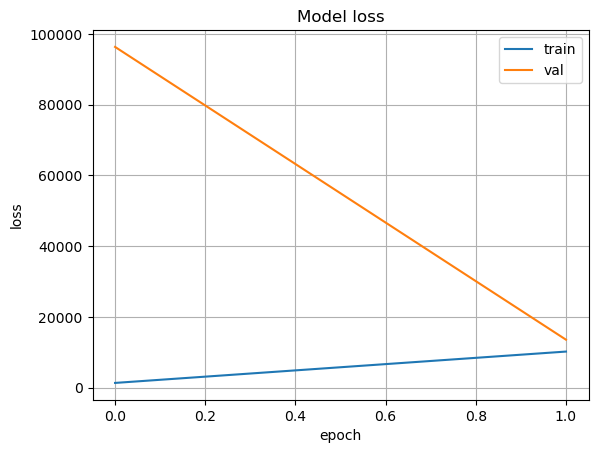

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'])
plt.grid(True)
plt.show()

# Performance

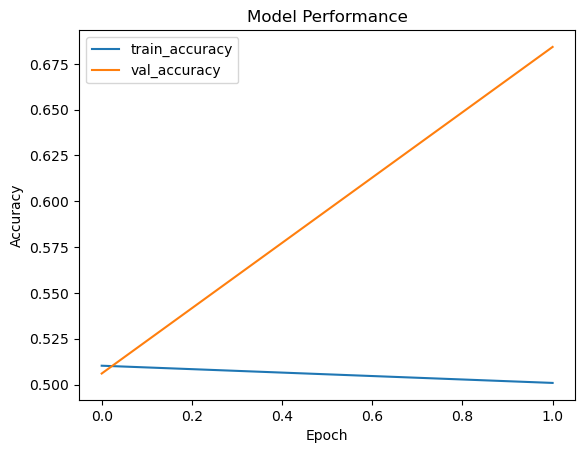

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and Testing

In [38]:
test_dataset2 = test_dataset.batch(1)

In [39]:
evals = lenet_model.evaluate(test_dataset2, return_dict = True)
evals

2757/2757 [==============================] - 8s 3ms/step - loss: 14931779.0000 - tp: 1360.0000 - fp: 1397.0000 - fn: 0.0000e+00 - tn: 0.0000e+00 - accuracy: 0.4933 - precision: 0.4933 - recall: 1.0000 - auc: 0.5000


{'loss': 14931779.0,
 'tp': 1360.0,
 'fp': 1397.0,
 'fn': 0.0,
 'tn': 0.0,
 'accuracy': 0.4932897984981537,
 'precision': 0.4932897984981537,
 'recall': 1.0,
 'auc': 0.5}

# Predict

In [40]:
lenet_model.predict(test_dataset2.take(1))[0][0]

1/1 [==============================] - 1s 578ms/step


1.0

In [41]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [42]:
parasite_or_not(lenet_model.predict(test_dataset2.take(1))[0][0])

1/1 [==============================] - 0s 487ms/step


'U'

1/1 [==============================] - 0s 10ms/step


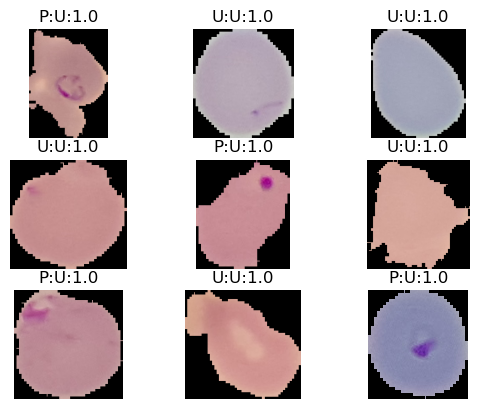

In [43]:
for i, (image, label) in enumerate(test_dataset2.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  res = lenet_model.predict(image)[0][0]
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(res)) + ":"+ str(round(res, 2)))
  plt.axis('off')

In [44]:
test_dataset2.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Visualising Confusion Matrix

In [45]:
inps = []
labels = []
for _,(x,y) in enumerate(test_dataset2):
    labels.append(y)
    inps.append(x)

In [46]:
labels[:5]

[<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>]

In [47]:
labels = np.array([i.numpy()[0] for i in labels])
print(labels)

[1 0 0 ... 0 0 1]


In [48]:
np.array(inps[0]).shape

(1, 100, 136, 3)

In [49]:
predicted = [lenet_model.predict(i) for i in inps ] #np.array(inps)[:,0,...])
len(predicted)

1/1 [==============================] - 0s 12ms/step


2757

In [50]:
pred_labels = np.squeeze(predicted)
pred_labels.shape

(2757,)

In [51]:
threshold = 0.5

cm = confusion_matrix(labels, pred_labels > threshold)
print(cm)

[[   0 1396]
 [   0 1361]]


Text(0.5, 58.7222222222222, 'Predicted')

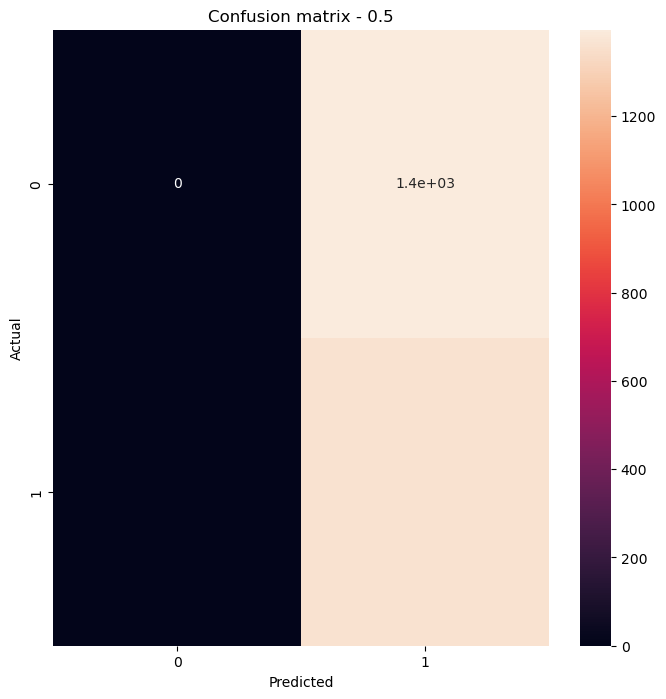

In [52]:
plt.figure(figsize = (8, 8))
sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('Predicted')

# ROC Plots

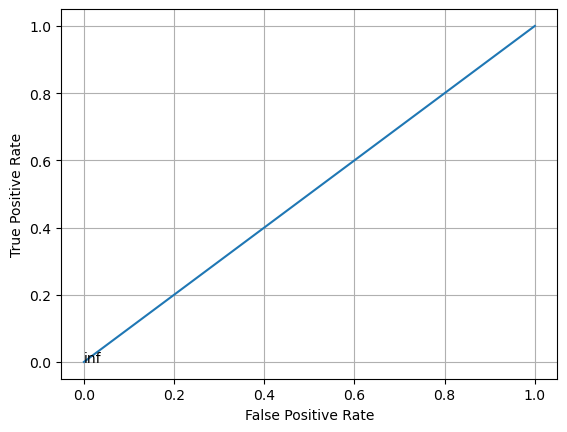

In [53]:
fp, tp ,threshoulds = roc_curve(labels, pred_labels)
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.grid()

skip = 50

for i in range(0, len(threshoulds), skip):
    plt.text(fp[i], tp[i], threshoulds[i])
plt.show()

In [54]:
f1 = f1_score(y_true= labels, y_pred= np.round(pred_labels))
f1

0.6610004856726566